# Genetic Algorithm for Pumped Storage Optimisation

In [6]:
import numpy as np
import pandas as pd
import polars as pl
import plotnine as pn
from tqdm.notebook import tqdm
import plotly.express as px
from IPython.display import display, clear_output
import importlib

import optuna
from optuna.trial import TrialState

background_colour = "#F2F2F2"
pn.theme_set(
    pn.theme_classic()
    + pn.theme(
        text=pn.element_text(family="monospace"),
        plot_background=pn.element_rect(
            fill=background_colour, colour=background_colour
        ),
        panel_background=pn.element_rect(
            fill=background_colour, colour=background_colour
        ),
        legend_background=pn.element_rect(
            fill=background_colour, colour=background_colour
        ),
    )
)

from Marginal import GA_discrete_actions

%load_ext blackcellmagic

The blackcellmagic extension is already loaded. To reload it, use:
  %reload_ext blackcellmagic


In [7]:
prices = (
    pl.read_csv("Data/spot_prices_utc.csv")
    .with_columns(pl.col("utc_time").str.to_datetime(), pl.col("spot").forward_fill())
    .drop_nulls()
)

example = prices.filter(
    pl.col("utc_time") >= pd.to_datetime("2022-01-01").tz_localize("UTC")
).head(24)

In [8]:
def evaluate_fitness(population, ps_params, prices):

    # To be written according to pumped storage optimisation problem
    fitness_scores = np.array([])

    for parameter_combination in population:

        water_level = ps_params["INITIAL_WATER_LEVEL"]
        fitness_score = 0

        for price in prices["spot"]:
            # Pump (marginal price  0)
            if parameter_combination[0] <= price:
                if water_level + ps_params["PUMP_RATE_M3H"] <= ps_params["MAX_STORAGE_M3"]:
                    fitness_score -= ps_params["PUMP_POWER_MW"] * price
                    water_level += ps_params["PUMP_RATE_M3H"]
                else:
                    fitness_score -= 10_000_000
            # Turbine (marginal price 1)
            if parameter_combination[1] >= price:
                if water_level - ps_params["TURBINE_RATE_M3H"] >= ps_params["MIN_STORAGE_M3"]:
                    fitness_score += ps_params["TURBINE_POWER_MW"] * price
                    water_level -= ps_params["TURBINE_RATE_M3H"]
                else:
                    fitness_score -= 10_000_000
            # Do nothing (0)
            # Nothing happens to the fitness score and the water level
        
        fitness_scores = np.append(fitness_scores, fitness_score)

    return fitness_scores

In [9]:
window_size = 24*1

prices = (
    pl.read_csv("Data/spot_prices_utc.csv")
    .with_columns(pl.col("utc_time").str.to_datetime(), pl.col("spot").forward_fill())
    .drop_nulls()
)

example = prices.filter(
    pl.col("utc_time") >= pd.to_datetime("2022-01-01").tz_localize("UTC")
).head(window_size)

ps_params = {
    "EFFICIENCY": 0.75,
    "MAX_STORAGE_M3": 5000,
    "MIN_STORAGE_M3": 0,
    "TURBINE_POWER_MW": 100,
    "PUMP_POWER_MW": 100,
    "TURBINE_RATE_M3H": 500,
    "MIN_STORAGE_MWH": 0,
    "INITIAL_WATER_LEVEL_PCT": 0,
}
ps_params["INITIAL_WATER_LEVEL"] = ps_params["INITIAL_WATER_LEVEL_PCT"] * ps_params["MAX_STORAGE_M3"]
ps_params["PUMP_RATE_M3H"] = ps_params["TURBINE_RATE_M3H"] * ps_params["EFFICIENCY"]
ps_params["MAX_STORAGE_MWH"] = (ps_params["MAX_STORAGE_M3"] / ps_params["TURBINE_RATE_M3H"]) * ps_params["TURBINE_POWER_MW"]


ga = GA_discrete_actions(
    dna_size=2,
    initial_marginal_prices=[example["spot"].mean(), example["spot"].mean()],
    elitism=0.1,
    population_size=1000,
    mutation_rate=0.5,
    survival_rate=0.25,
    mutation_decay=0.99,
    mutation_limit=0.01,
    mutation_size=1
)

In [5]:
population = ga.initial_population
average_fitnesses = []
best_fitnesses = []
generation = 0
average_marginals = []

while True:
    if (generation == 0) or (np.mean(average_fitnesses[-15:]) < ga.best_fitness * 0.99):
        population = ga.evolve(
            population=population,
            fitnesses=evaluate_fitness(
                population=population, ps_params=ps_params, prices=example
            ),
        )

        average_fitnesses.append(ga.average_fitness)
        best_fitnesses.append(ga.best_fitness)
        average_marginals.append(np.mean(population, axis=0))

        if generation % 25 == 0:
            print(
                f"Generation: {generation}, Best Fitness: {ga.best_fitness:,.0f}, Average Fitness: {ga.average_fitness:,.0f}, Mutation Rate: {ga.mutation_rate:,.2f}"
            )
            # clear_output(wait=True)

        generation += 1

    else:
        break

    if generation == 100:
        break

Generation: 0, Best Fitness: 0, Average Fitness: -98,998,981, Mutation Rate: 0.49
Generation: 25, Best Fitness: 0, Average Fitness: -110,080, Mutation Rate: 0.39
Generation: 50, Best Fitness: 0, Average Fitness: -110,080, Mutation Rate: 0.30
Generation: 75, Best Fitness: 0, Average Fitness: -110,080, Mutation Rate: 0.23


<Axes: >

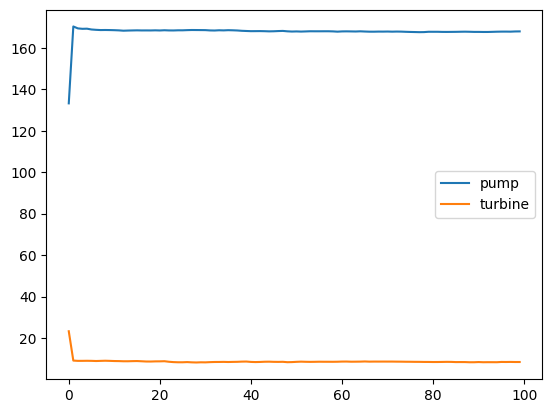

In [10]:
pd.DataFrame(average_marginals).rename({0:"pump", 1:"turbine"}, axis=1).plot()

In [14]:
ga.best_dna

array([168.05510986,  10.27009889])

In [15]:
history = pd.DataFrame(
    {
        "generation": np.arange(1, len(average_fitnesses) + 1),
        "average": average_fitnesses,
        "best": best_fitnesses,
    }
)

history.head()

,generation,average,best
0,1,-1.011835e+08,0.0
1,2,-2.050266e+07,0.0
2,3,-1.309068e+05,0.0
3,4,-1.200803e+05,0.0
4,5,-1.100803e+05,0.0


In [16]:
ga.best_fitness

0.0

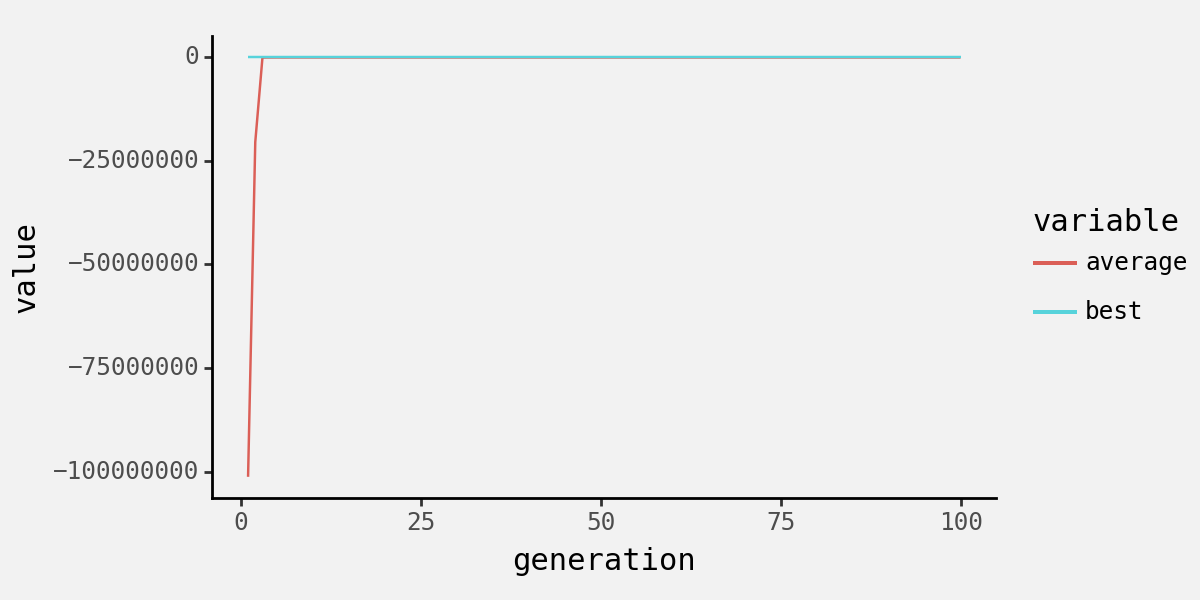

<Figure Size: (600 x 300)>

In [17]:
(
    pn.ggplot(
        data=(
            pd.DataFrame(
                {
                    "average": average_fitnesses,
                    "best": best_fitnesses,
                    "generation": np.arange(1, len(average_fitnesses) + 1),
                }
            )
            # .tail(len(average_fitnesses)-10)
            .melt(id_vars="generation")
        ),
        mapping=pn.aes(x="generation", y="value", colour="variable"),
    )
    + pn.geom_line()
    + pn.theme(figure_size=[6, 3])
    # + pn.scale_y_log10()
)

In [18]:
pd.DataFrame(
                {
                    "average": average_fitnesses,
                    "best": best_fitnesses,
                    "generation": np.arange(1, len(average_fitnesses) + 1),
                }
            ).to_csv("history.csv", index=False)

In [19]:
best_profile = (
    example.to_pandas().assign(
        action=ga.best_dna,
        colour_id=lambda x: np.select(
            [x.action == -1, x.action == 0, x.action == 1],
            ["pump", "nothing", "turbine"],
        ),
        water_level=lambda x: ps_params["INITIAL_WATER_LEVEL"]
        + np.select(
            [x.action == -1, x.action == 1],
            [ps_params["PUMP_RATE_M3H"], -ps_params["TURBINE_RATE_M3H"]],
            0,
        ).cumsum(),
    )
)

best_profile.head()

ValueError: Length of values (2) does not match length of index (24)

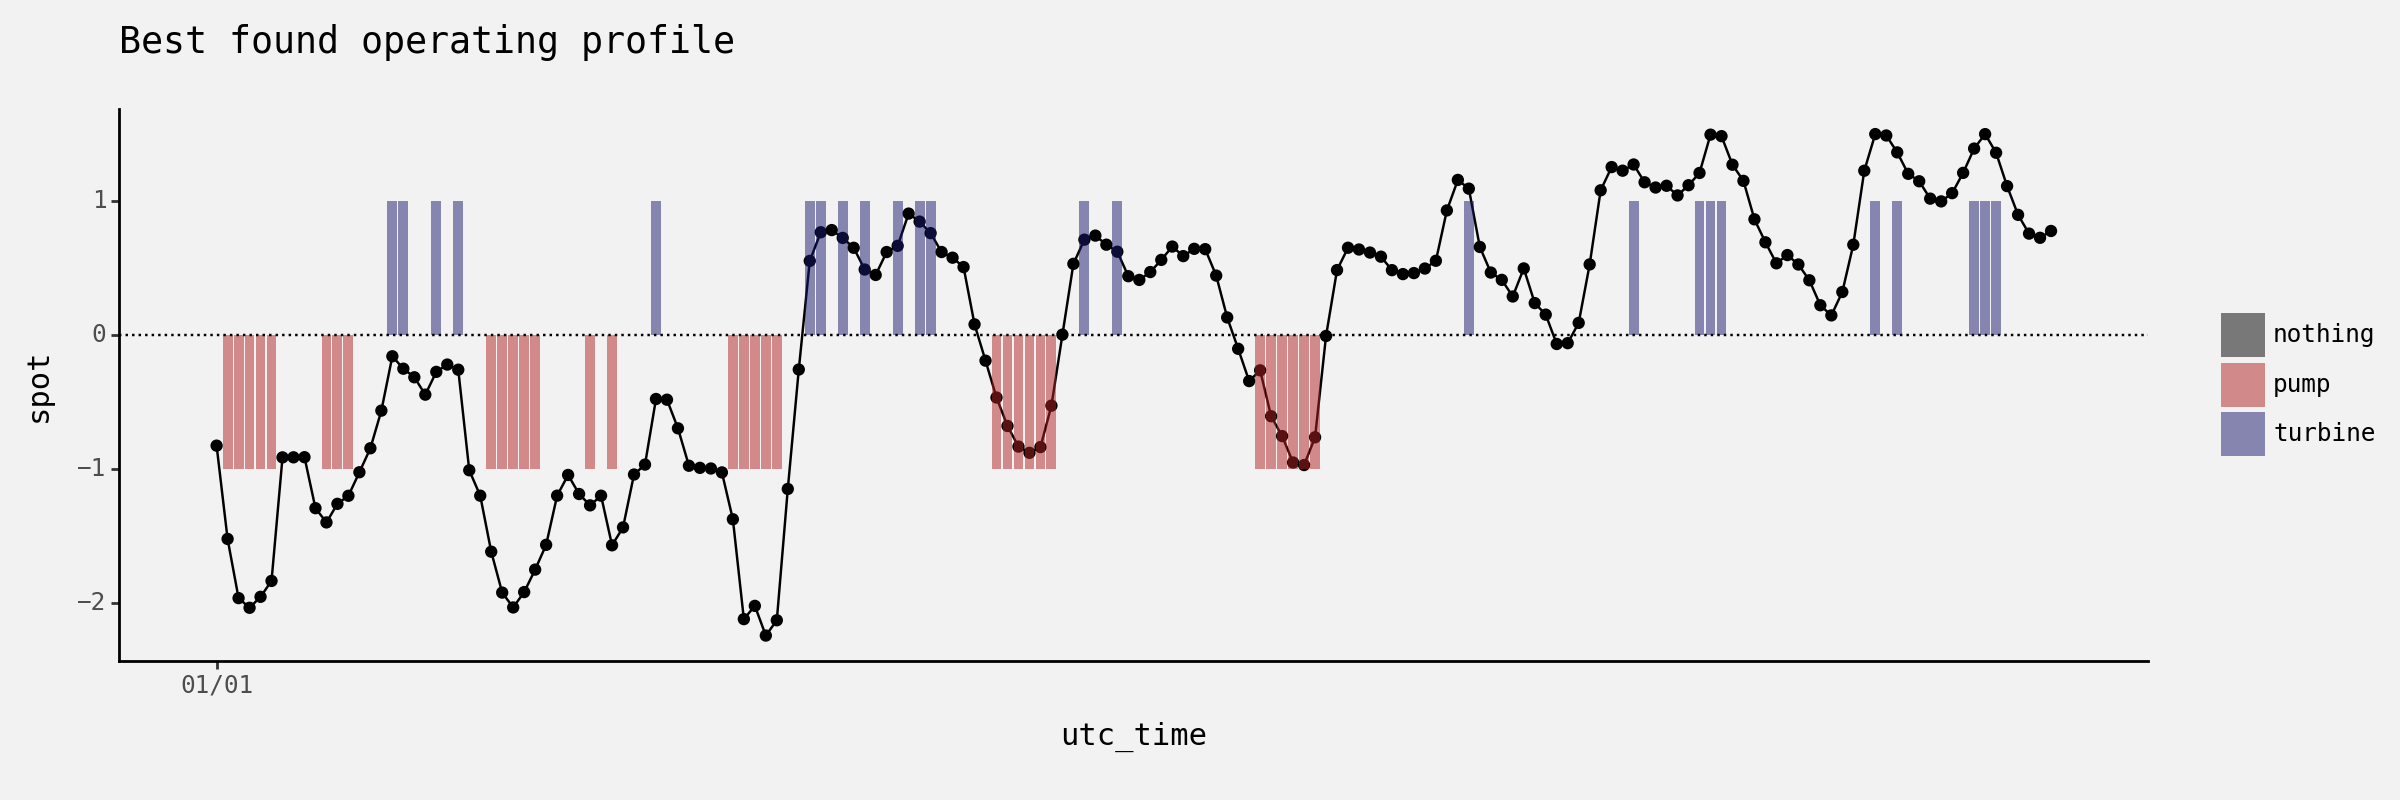

<Figure Size: (1200 x 400)>

In [ ]:
(
    pn.ggplot(
        data=best_profile.assign(
            spot=lambda x: (x.spot - x.spot.mean()) / x.spot.std()
        ),
        mapping=pn.aes(x="utc_time"),
    )
    + pn.geom_line(pn.aes(y="spot"))
    + pn.geom_point(pn.aes(y="spot"))
    + pn.geom_col(pn.aes(y="action", fill="colour_id"), alpha=0.5)
    + pn.labs(title="Best found operating profile")
    + pn.scale_fill_manual(values=["black", "firebrick", "midnightblue"])
    + pn.geom_hline(yintercept=0, linetype="dotted")
    + pn.scale_x_date(date_breaks="1 month", date_labels="%d/%m")
    + pn.theme(figure_size=[12, 4], legend_title=pn.element_blank())
)

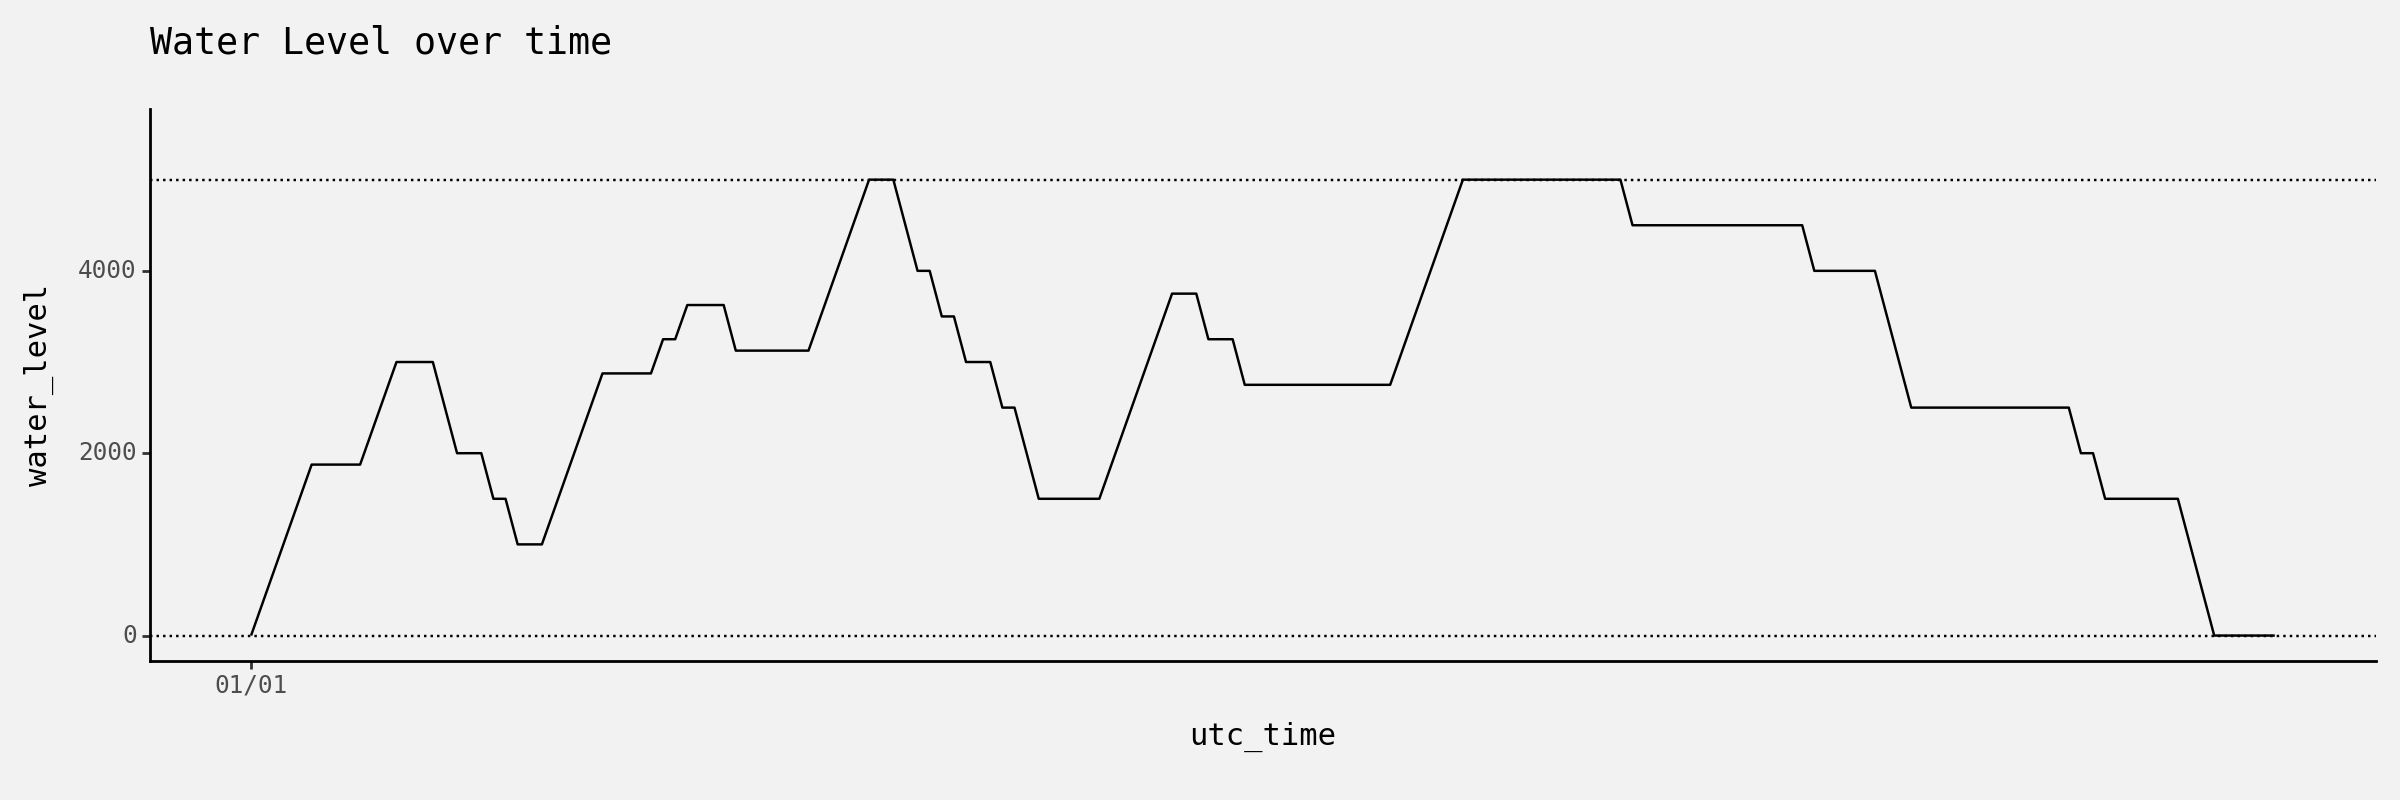

<Figure Size: (1200 x 400)>

In [ ]:
(
    pn.ggplot(data=best_profile, mapping=pn.aes(x="utc_time", y="water_level"))
    + pn.geom_line()
    + pn.labs(title="Water Level over time")
    + pn.geom_hline(yintercept=ps_params["MAX_STORAGE_M3"], linetype="dotted")
    + pn.geom_hline(yintercept=ps_params["MIN_STORAGE_M3"], linetype="dotted")
    + pn.scale_x_date(date_breaks="1 month", date_labels="%d/%m")
    + pn.coord_cartesian(ylim=[0, best_profile.water_level.max()*1.1])
    + pn.theme(figure_size=[12, 4], legend_title=pn.element_blank())
)

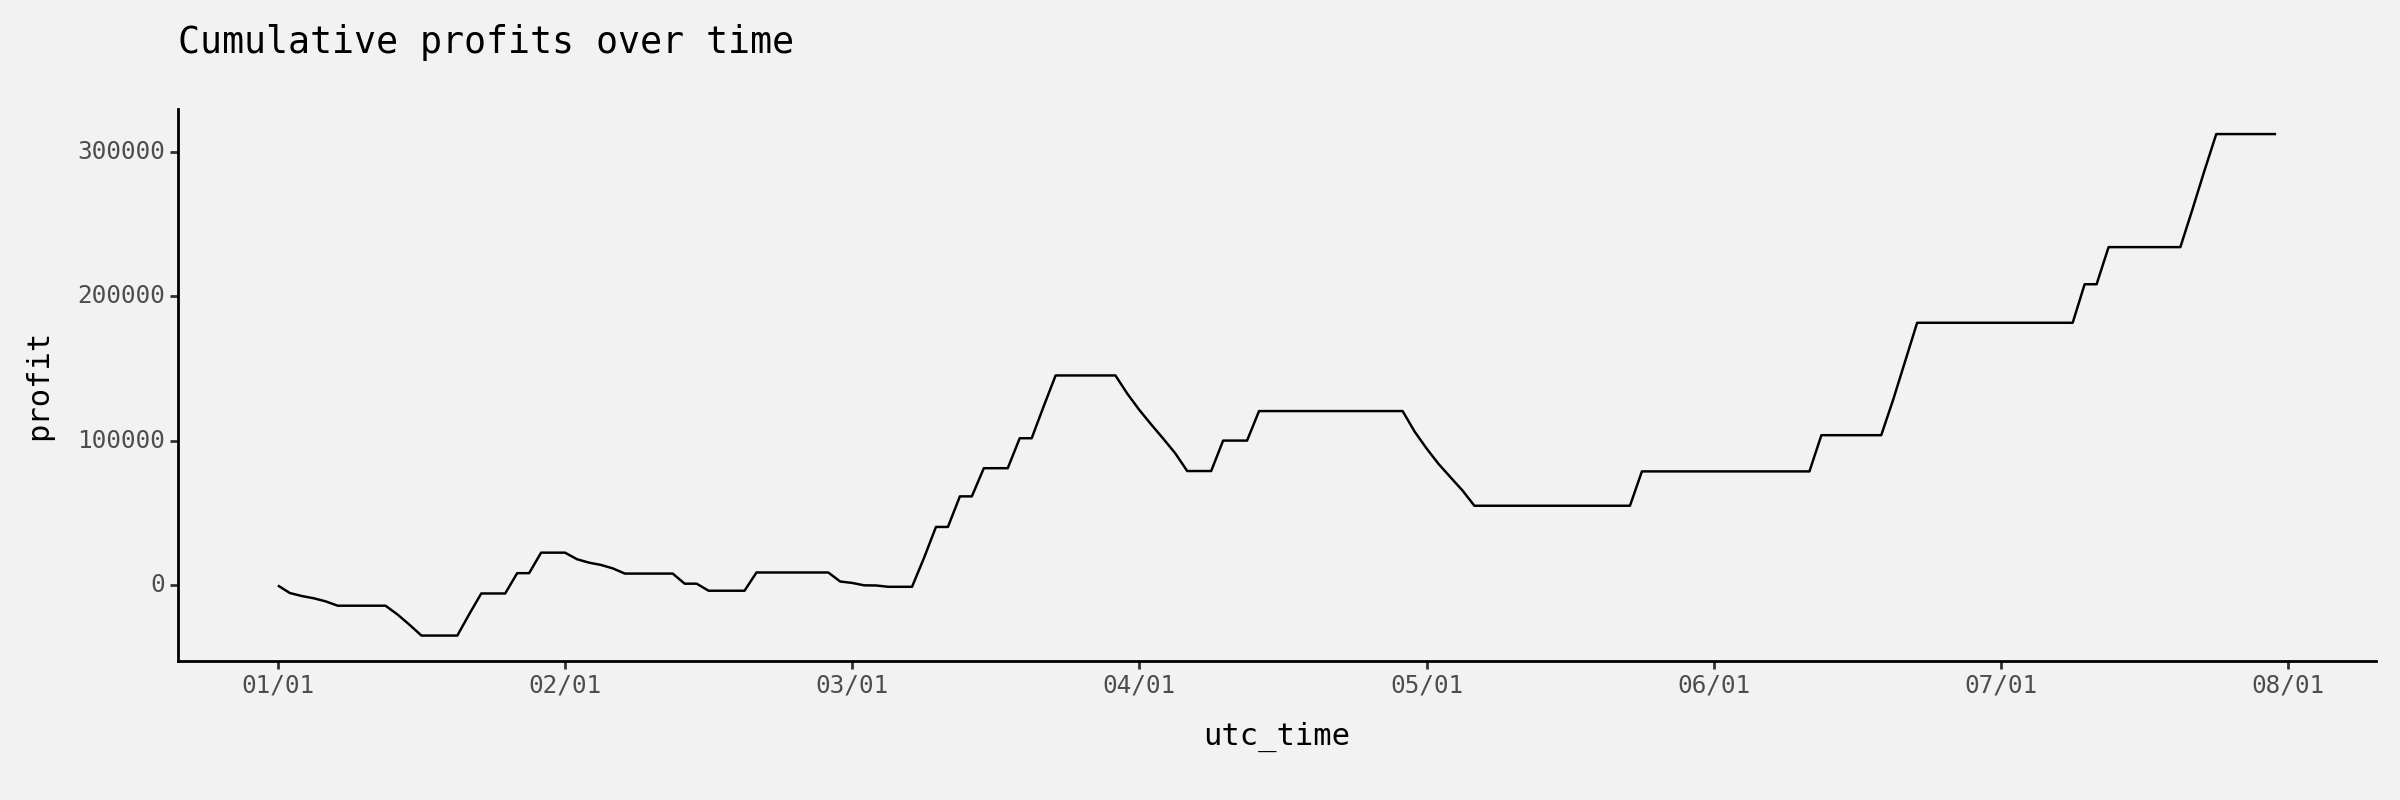

<Figure Size: (1200 x 400)>

In [ ]:
(
    pn.ggplot(
        data=(
            best_profile.assign(
                profit=lambda x: np.select(
                    [x.action == -1, x.action == 1],
                    [
                        -ps_params["PUMP_POWER_MW"] * x.spot,
                        ps_params["TURBINE_POWER_MW"] * x.spot,
                    ],
                )
            ).assign(profit=lambda x: x.profit.cumsum())
        ),
        mapping=pn.aes(x="utc_time", y="profit"),
    )
    + pn.geom_line()
    + pn.labs(title="Cumulative profits over time")
    + pn.scale_x_date(date_breaks="1 day", date_labels="%d/%m")
    + pn.theme(figure_size=[12, 4], legend_title=pn.element_blank())
)

In [ ]:
ga.best_fitness

65706042.0

### Tuning the Hyperparameters with Optuna

In [ ]:
window_size = 24*3

example = prices.filter(
    pl.col("utc_time") >= pd.to_datetime("2022-07-18").tz_localize("UTC")
).head(window_size)

ps_params = {
    "EFFICIENCY": 0.75,
    "MAX_STORAGE_M3": 4000,
    "MIN_STORAGE_M3": 0,
    "TURBINE_POWER_MW": 100,
    "PUMP_POWER_MW": 100,
    "TURBINE_RATE_M3H": 100,
    "MIN_STORAGE_MWH": 0,
    "INITIAL_WATER_LEVEL_PCT": 0,
}
ps_params["INITIAL_WATER_LEVEL"] = ps_params["INITIAL_WATER_LEVEL_PCT"] * ps_params["MAX_STORAGE_M3"]
ps_params["PUMP_RATE_M3H"] = ps_params["TURBINE_RATE_M3H"] * ps_params["EFFICIENCY"]
ps_params["MAX_STORAGE_MWH"] = (ps_params["MAX_STORAGE_M3"] / ps_params["TURBINE_RATE_M3H"]) * ps_params["TURBINE_POWER_MW"]

In [ ]:
def objective(trial):
    params = {
        "elitism": trial.suggest_float("elitism", 0, 0.5),
        "mutation_rate": trial.suggest_float("mutation_rate", 0, 0.5),
        "mutation_sigma": trial.suggest_float("mutation_sigma", 0, 0.5),
        "mutation_decay": trial.suggest_float("mutation_decay", 0.8, 0.9999),
    }

    ga = GA_discrete_actions(
        dna_size=window_size,
        discrete_action_space=[-1, 0, 1],
        elitism=params["elitism"],
        population_size=200,
        mutation_rate=params["mutation_rate"],
        mutation_sigma=params["mutation_sigma"],
        mutation_decay=params["mutation_decay"],
        mutation_limit=0.01,
    )

    population = ga.initial_population

    for generation in range(100):
        population = ga.evolve(
            population=population,
            fitnesses=evaluate_fitness(
                population=population, ps_params=ps_params, prices=example
            ),
        )
    
    return ga.average_fitness


In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50, timeout=3600*1)

In [ ]:
pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

# Display the study statistics
print("\nStudy statistics: ")
print(f"  Number of finished trials: {len(study.trials)}")
print(f"  Number of pruned trials: {len(pruned_trials)}")
print(f"  Number of complete trials: {len(complete_trials)}")

In [ ]:
study.best_params

In [ ]:
study.best_value

### Formulating the Problem as MILP

First: Does it find global optimum?
How to specify the problem and constraints?
How to solve the problem numerically with Python?

### Genetic Algorithm Library in Python

Parallelise? More advanced types of genetic algorithm?

### NEAT

Make a decision with a neural network at every point in time.